# Data Cleaning and Pre-processing

In [37]:
# Import all the modules 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


PCA has 4 steps 
1) Data Standardization 
2) Calculate the Covariance 
3) Find the principal components 
4) Transform the data (Visualization and Analysis). But first we need to do: 1) Data consolidation and 2) Data Pre-processing and cleaning.

## This notebook follows the development of data cleaning procedurs for our dataset and visualises the data before and after

Check for missing or inconsistent data and decide how to handle it (e.g., imputation or removal).
Ensure that all data types are correct (e.g., DATE should be a date type, HOUR_0 to HOUR_23 should be numeric). For example, for applying Imputation on non-numeric data (objects) for handling Nan values, first we need to convert them to a numeric. However, HOUR_0 to HOUR_23 were by default float.
Convert categorical variables like ISPRIVATEPERSON into a numerical form that PCA can work with, using encoding methods like One-Hot Encoding or Label Encoding.
Exclude non-numeric columns like CUSTOMER and AREA from PCA, or find a way to numerically encode them if they are relevant to your analysis.

In [2]:
import utils.KEprocessing

# List of filenames
filenames = ['data/lnu_2020.csv', 'data/lnu_2021.csv', 'data/lnu_2022.csv', 'data/lnu_2023.csv']
combined_df = utils.KEprocessing.consolidate_data(filenames)

## Power usage per year to see the outliers ( too high or too low consumption that is incorrect)
 
(High values compared to the power usage threshold which I defined for Residential:0.05MWh and Commercial:15MWh, negative values, and Nan values)

In [ ]:

# List of unique years in the data
years = combined_df['YEAR'].unique()

# Plotting boxplots for each year
for year in years:
    # Selecting only the data for current year
    year_data = combined_df[combined_df['YEAR'] == year]
    
    # Selecting only the hour columns
    hours_data = year_data.filter(regex='^HOUR_')

    # Plotting
    plt.figure(figsize=(15, 5))
    hours_data.boxplot()
    plt.title(f'Hourly Power Consumption Boxplot for {year}')
    plt.ylabel('Power Consumption (MWh)')
    plt.xlabel('Hour of the Day')
    plt.xticks(rotation=90)
    plt.grid(False)
    plt.show()

## Quantify how many NaN values there are in total

In [7]:
# Get unique years in the data
years = combined_df['YEAR'].unique()

# Count NaN values for each year
for year in years:
    nan_count = combined_df[combined_df['YEAR'] == year].isna().sum().sum()
    print(f"NaN values in year {year}: {nan_count}")

NaN values in year 2020: 12365
NaN values in year 2021: 29255
NaN values in year 2022: 7039
NaN values in year 2023: 0


## Mean imputation of NaN values in power consumption

Mean Imputation is by default column-wise which means imputation strategy will replace missing values (NaNs) with the mean value of the respective column.

Apply row-wise Mean Imputation which means: replacing all the outliers: 
(High values compared to the power usage threshold which I defined for Residential:0.03MWh and Commercial:3MWh, negative values, and Nan values).

 If we are still seeing null values after performing the row-wise mean imputation, it could be due to that all values in a row are NaN or invalid: If an entire row (for all the hourly columns) consists of NaN or invalid values, the mean would also be NaN since there are no valid values to calculate the mean from. Ex: Customer id 1060676202 in 2020 Solution: define the minimum number of non-NaN hourly values required to keep a row.

In [4]:
# Define your thresholds
residential_threshold = 0.03  # 0.03 MWh for residential
commercial_threshold = 3      # 3 MWh for commercial

# Define the minimum number of non-NaN hourly values required to keep a row
min_non_nan_values = 3

# Apply the function to the combined DataFrame
combined_df_noNA = utils.KEprocessing.replace_invalid_with_row_mean(combined_df, residential_threshold, commercial_threshold, min_non_nan_values)

/Users/oxana/projects/Research-KalmarEnergy/utils/KEprocessing.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[hour_columns] = df_filtered[hour_columns].mask((df_filtered[hour_columns] < 0) | (df_filtered[hour_columns].gt(thresholds, axis=0)))
/Users/oxana/projects/Research-KalmarEnergy/utils/KEprocessing.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[hour_columns] = df_filtered[hour_columns].apply(lambda x: x.fillna(row_means[x.name]), axis=1)


## Test if there is still any Nan values in the dataframe!

In [8]:
# Find rows in combined_df that still have any null values
rows_with_nan = combined_df_noNA[combined_df_noNA.isnull().any(axis=1)]

# Display the rows with NaN values
print(rows_with_nan)

Empty DataFrame
Columns: [CUSTOMER, AREA, ISPRIVATEPERSON, DATE, HOUR_0, HOUR_1, HOUR_2, HOUR_3, HOUR_4, HOUR_5, HOUR_6, HOUR_7, HOUR_8, HOUR_9, HOUR_10, HOUR_11, HOUR_12, HOUR_13, HOUR_14, HOUR_15, HOUR_16, HOUR_17, HOUR_18, HOUR_19, HOUR_20, HOUR_21, HOUR_22, HOUR_23, YEAR]
Index: []

[0 rows x 29 columns]


## Plot boxplot again to see the difference

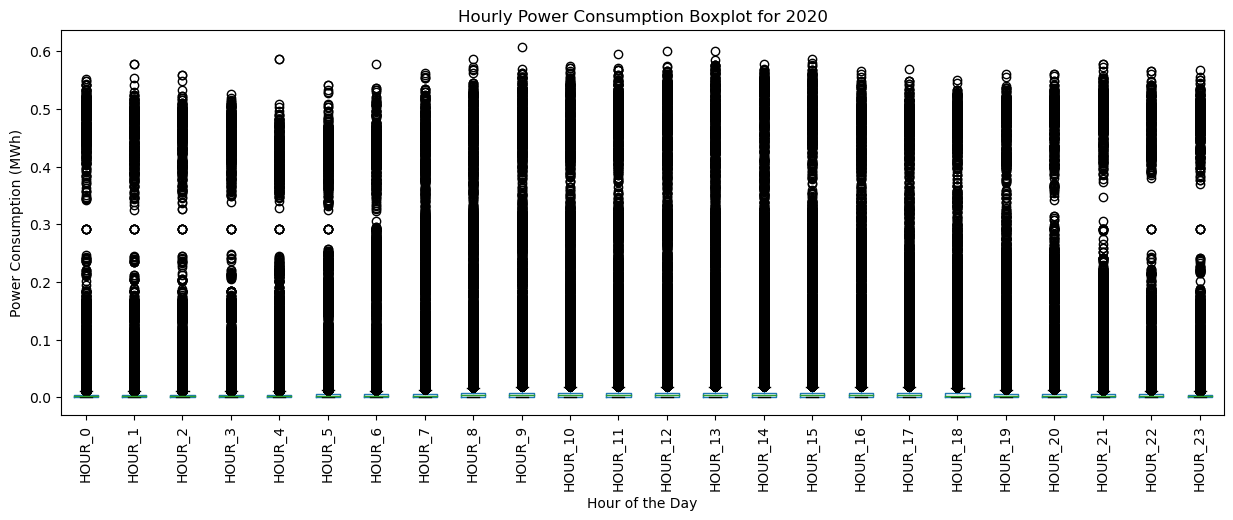

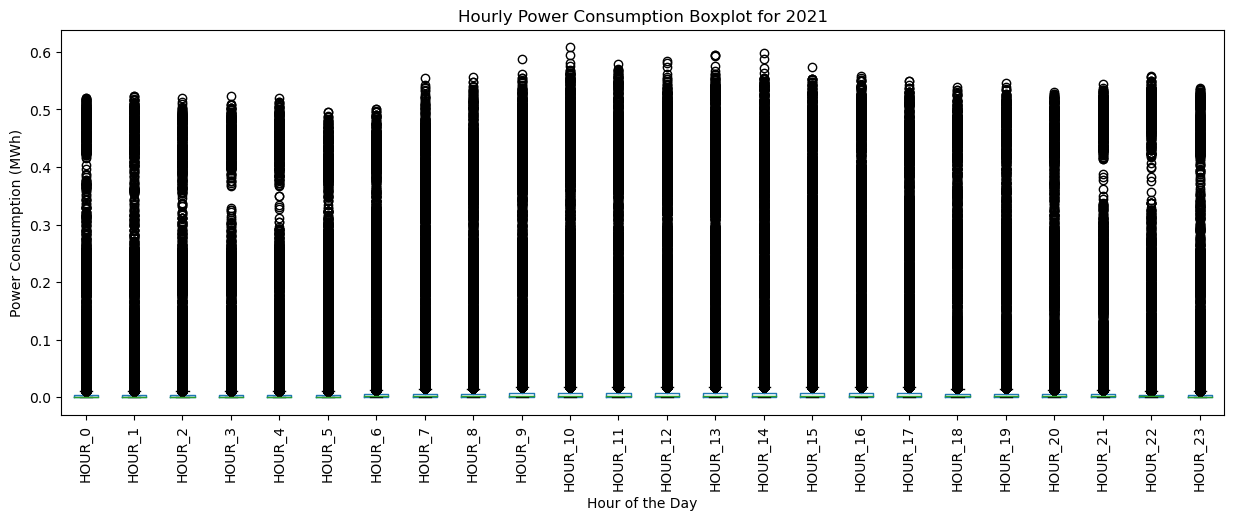

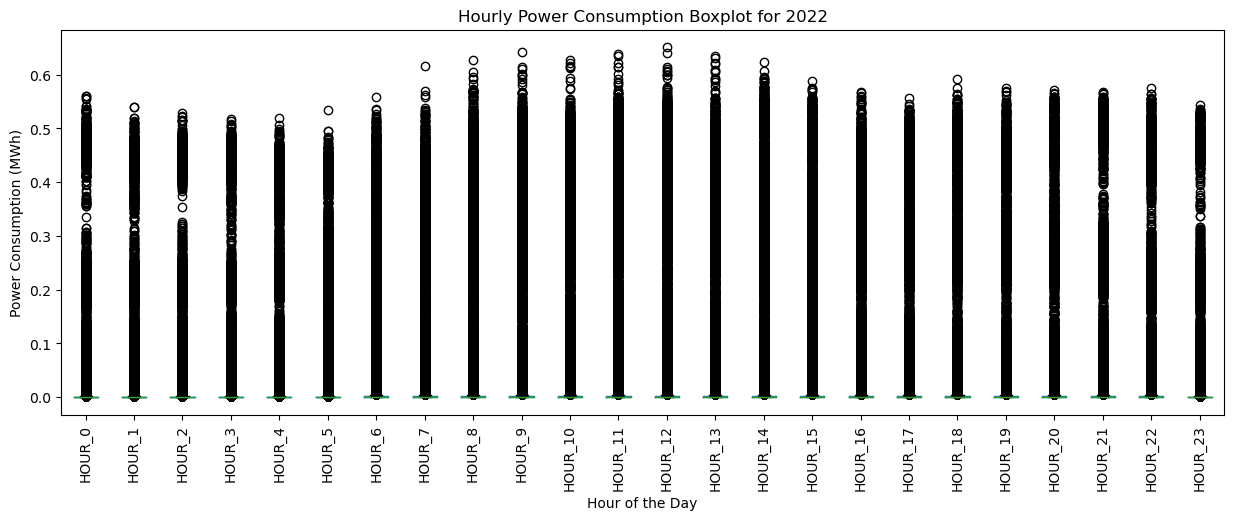

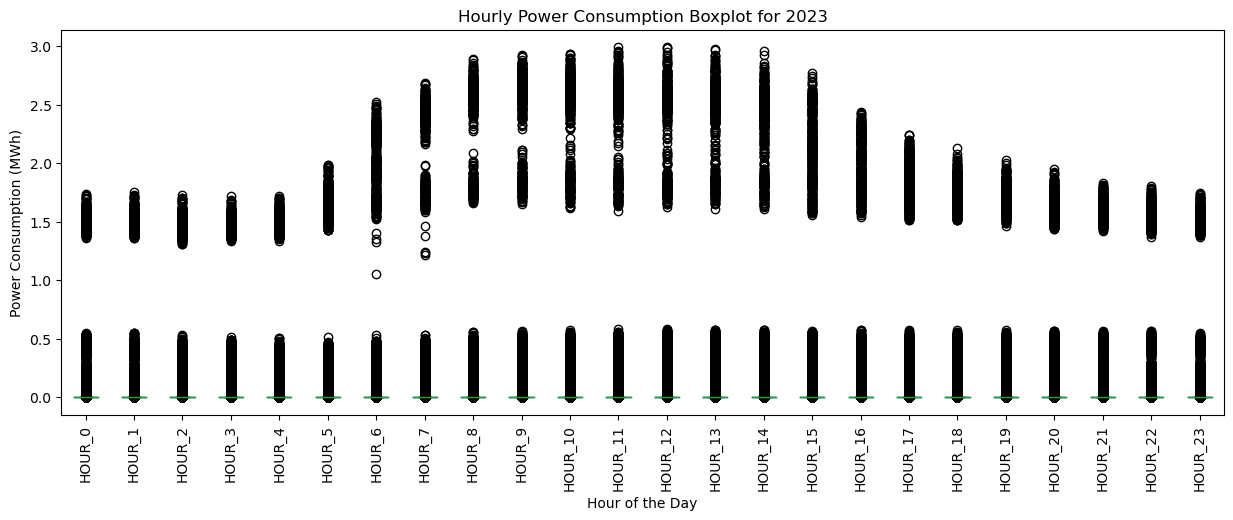

In [42]:
# List of unique years in the data
years = combined_df_noNA['YEAR'].unique()

# Plotting boxplots for each year
for year in years:
    # Selecting only the data for current year
    year_data = combined_df_noNA[combined_df_noNA['YEAR'] == year]
    
    # Selecting only the hour columns
    hours_data = year_data.filter(regex='^HOUR_')

    # Plotting
    plt.figure(figsize=(15, 5))
    hours_data.boxplot()
    plt.title(f'Hourly Power Consumption Boxplot for {year}')
    plt.ylabel('Power Consumption (MWh)')
    plt.xlabel('Hour of the Day')
    plt.xticks(rotation=90)
    plt.grid(False)
    plt.show()
    

# NaN values might not actually be as big of a problem as zeros

## Create column 'One_Day_Power'

In [10]:
# Define the hourly columns
hourly_columns = [f'HOUR_{i}' for i in range(24)]

# Calculate the sum of the hourly consumption for each record and create a new column 'One_Day_Power'
combined_df['One_Day_Power'] = combined_df[hourly_columns].sum(axis=1)

In [11]:
print(combined_df[['One_Day_Power']].head())

   One_Day_Power
0          0.261
1          0.228
2          0.243
3          0.243
4          0.265


In [12]:
# Count the number of rows with One_Day_Power equal to zero
zero_power_count = (combined_df['One_Day_Power'] == 0).sum()

print(f"Number of rows with One_Day_Power equal to zero: {zero_power_count}")

Number of rows with One_Day_Power equal to zero: 1040187


## A lot More 0 consumption records in 2023 
Investigate the rows with zero in their hourly power consumption and identify the time of the year, area, and customers they belong to
you can filter your DataFrame for these rows and then examine the 'DATE', 'AREA', and 'CUSTOMER' columns

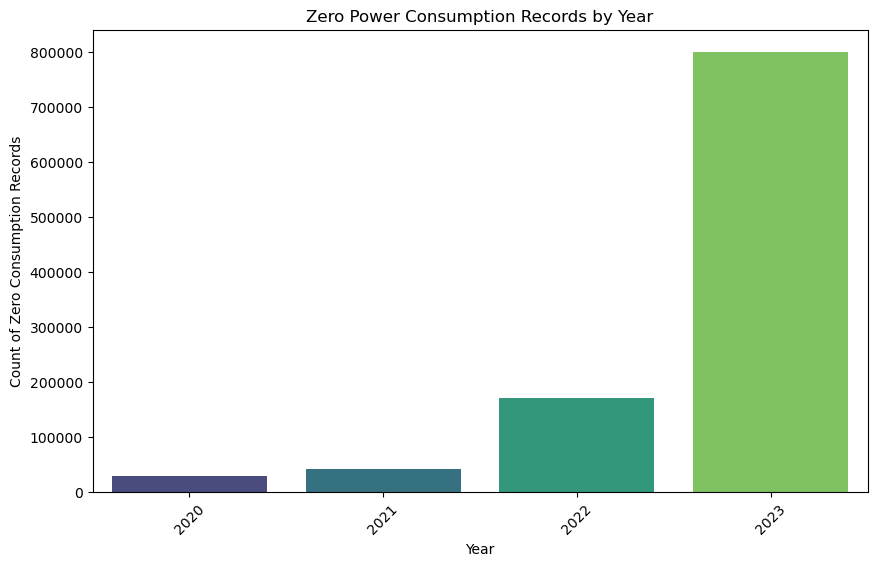

Zero Power Consumption Records by Year:
YEAR
2020     28963
2021     40405
2022    170979
2023    799840
Name: count, dtype: int64


In [15]:
# Filter rows where 'One_Day_Power' is zero
zero_power_df = combined_df[combined_df['One_Day_Power'] == 0]

# Get the count of zero consumption records for each year
zero_power_by_year = zero_power_df['YEAR'].value_counts().sort_index()

# Now let's visualize the distribution over years using a bar plot with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=zero_power_by_year.index.astype(str), y=zero_power_by_year.values, palette="viridis")
plt.title('Zero Power Consumption Records by Year')
plt.xlabel('Year')
plt.ylabel('Count of Zero Consumption Records')
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.show()

# Display the count of zero consumption records by year
print("Zero Power Consumption Records by Year:")
print(zero_power_by_year)


## Now compare zero records to NA record

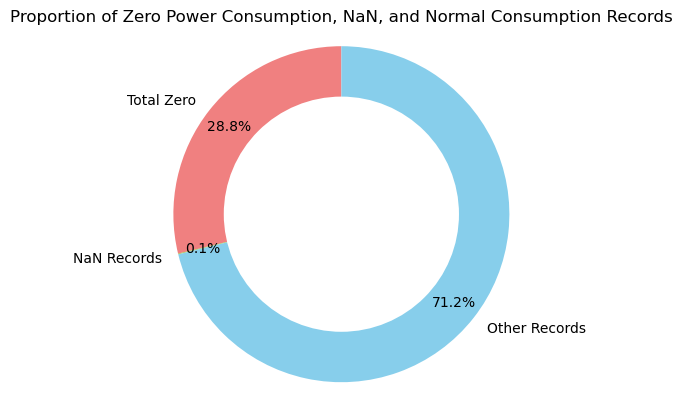

Zero Power Consumption Records by Year:
YEAR
2020     28963
2021     40405
2022    170979
2023    799840
Name: count, dtype: int64
NaN Records by Year:
YEAR
2020     582
2021    1331
2022     398
Name: count, dtype: int64


In [41]:
# Calculate the sum of NaN values in the consumption columns
combined_df['One_Day_Power_NaN'] = combined_df[hourly_columns].isna().sum(axis=1)

# Aggregate across all years
total_zero = combined_df[combined_df['One_Day_Power'] == 0].shape[0]
total_nan = combined_df[combined_df['One_Day_Power_NaN'] > 0].shape[0]
total_normal = combined_df.shape[0] - total_zero - total_nan

sizes = [total_zero, total_nan, total_normal]
labels = ['Total Zero', 'NaN Records', 'Other Records']


fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, 
       colors=['lightcoral', 'yellowgreen', 'skyblue'])

# Draw a white circle at the center to create a donut chart
centre_circle = plt.Circle((0,0), 0.70, color='black', fc='white', linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Proportion of Zero Power Consumption, NaN, and Normal Consumption Records')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

# Display the count of zero consumption records by year
print("Zero Power Consumption Records by Year:")
print(zero_power_by_year)

# Display the count of NaN records by year
print("NaN Records by Year:")
print(nan_power_by_year)

/var/folders/gv/7bjgqyhj6td4g_cktv1tvblw0000gq/T/ipykernel_10088/2335747545.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zero_power_df['DATE'] = pd.to_datetime(zero_power_df['DATE'])
/var/folders/gv/7bjgqyhj6td4g_cktv1tvblw0000gq/T/ipykernel_10088/2335747545.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zero_power_df['MONTH'] = zero_power_df['DATE'].dt.month


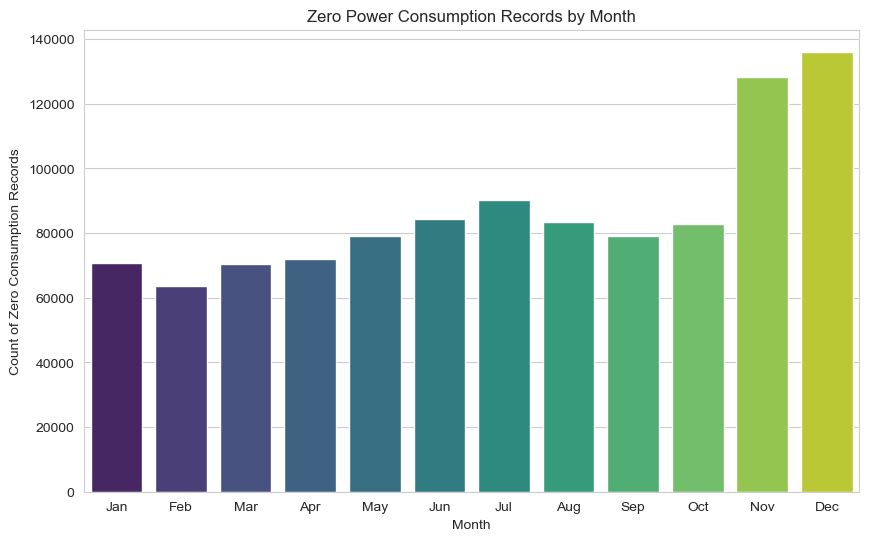

Top Areas with Zero Consumption:
AREA
Malmen         428963
Kvarnholmen    334768
Berga          207997
Stensö          68252
Name: count, dtype: int64

Top Customers with Zero Consumption:
CUSTOMER
1060608225    1461
1060696700    1461
1060621311    1461
1060603914    1459
1060753649    1459
Name: count, dtype: int64


In [32]:
# Filter rows where 'One_Day_Power' is zero
zero_power_df = combined_df[combined_df['One_Day_Power'] == 0]

# Check the distribution of these zero consumption records over different months (which can indicate seasons)
zero_power_df['DATE'] = pd.to_datetime(zero_power_df['DATE'])
zero_power_df['MONTH'] = zero_power_df['DATE'].dt.month

# Get the count of zero consumption records for each month
zero_power_by_month = zero_power_df['MONTH'].value_counts().sort_index()

# Get the count of zero consumption records for each area
zero_power_by_area = zero_power_df['AREA'].value_counts()

# Get the count of zero consumption records for each customer
zero_power_by_customer = zero_power_df['CUSTOMER'].value_counts()

# Now let's visualize the distribution over months using a bar plot with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=zero_power_by_month.index, y=zero_power_by_month.values, palette="viridis")
plt.title('Zero Power Consumption Records by Month')
plt.xlabel('Month')
plt.ylabel('Count of Zero Consumption Records')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

# If needed, display the top areas and customers with zero consumption
print("Top Areas with Zero Consumption:")
print(zero_power_by_area.head())  # Adjust the number of rows to display as needed

print("\nTop Customers with Zero Consumption:")
print(zero_power_by_customer.head())  # Adjust the number of rows to display as needed

## Visualize zeros in the entire dataset

<Axes: >

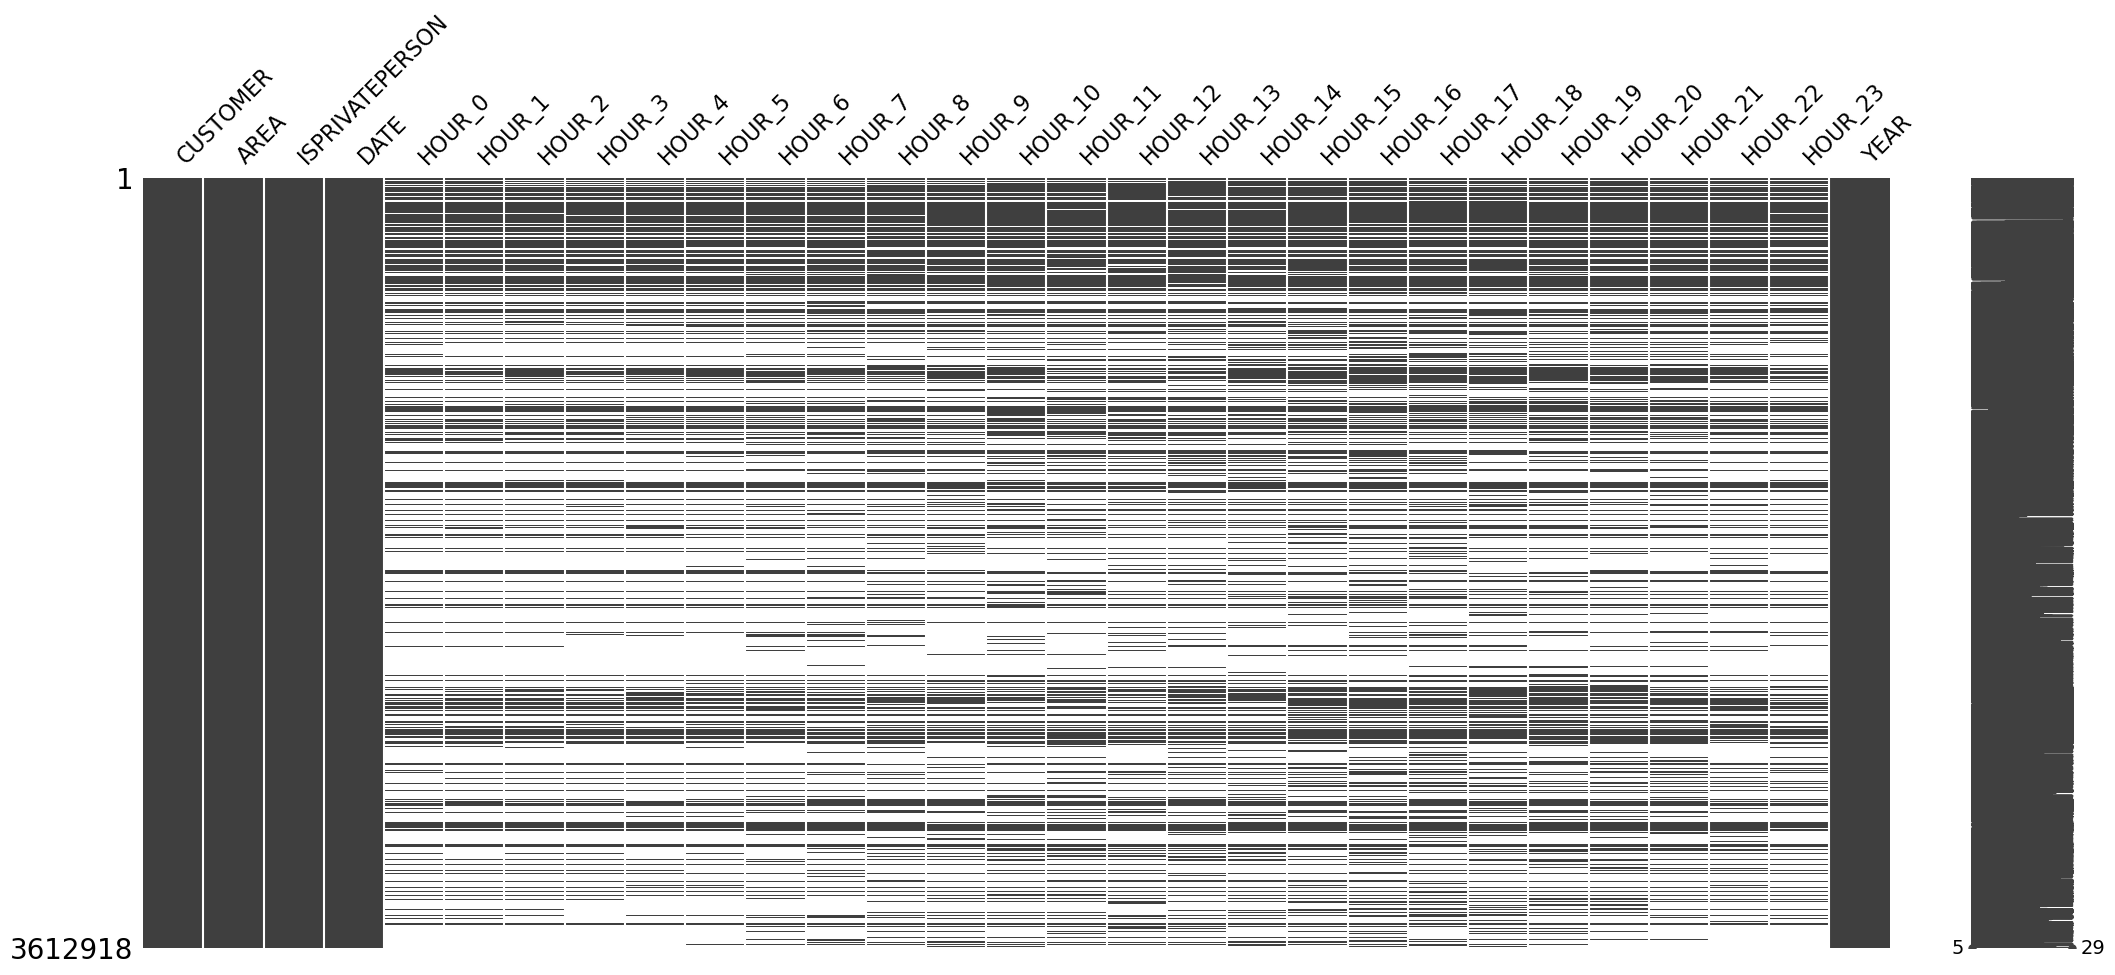

In [43]:
import missingno as msno
import numpy as np 
# Copy your dataframe in case you need the original data later.
df_copy = combined_df_noNA.copy()
# Replace all zeros with NaN
df_copy.replace(0, np.nan, inplace=True)
# Now you can visualize zeros (now as NaNs) using msno
msno.matrix(df_copy)

In [34]:
# Count the number of unique customers with zero 'One_Day_Power'
unique_zero_power_customers = zero_power_df['CUSTOMER'].nunique()

print(f"Number of unique customers with zero 'One_Day_Power': {unique_zero_power_customers}")

Number of unique customers with zero 'One_Day_Power': 5339


In [35]:
# Filter rows where 'One_Day_Power' is zero
zero_power_customers = combined_df[combined_df['One_Day_Power'] == 0]

# Group by 'AREA' and count the unique 'CUSTOMER' entries within each group
unique_customers_per_area = zero_power_customers.groupby('AREA')['CUSTOMER'].nunique()

# Display the unique number of customers per area
print(unique_customers_per_area)

AREA
Berga          1397
Kvarnholmen    1502
Malmen         2033
Stensö          407
Name: CUSTOMER, dtype: int64


          AREA  One_Day_Power
1  Kvarnholmen   87800.534625
2       Malmen   74599.123320
3       Stensö   43664.611725
0        Berga   32095.614718


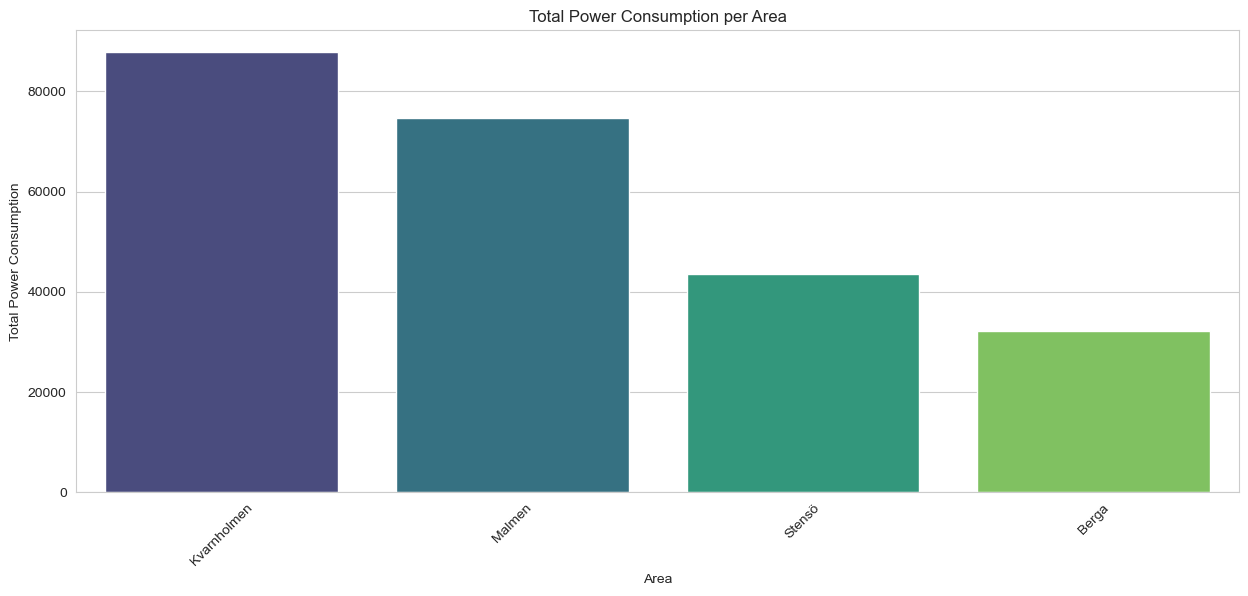

In [36]:
# Sum the 'One_Day_Power' for each area
power_consumption_per_area = combined_df.groupby('AREA')['One_Day_Power'].sum().reset_index()

# Sort the results to see the areas with the highest consumption at the top
power_consumption_per_area = power_consumption_per_area.sort_values(by='One_Day_Power', ascending=False)

# Display the power consumption per area
print(power_consumption_per_area)

# Now let's visualize the power consumption per area using Seaborn
plt.figure(figsize=(15, 6))
sns.barplot(data=power_consumption_per_area, x='AREA', y='One_Day_Power', palette="viridis")
plt.title('Total Power Consumption per Area')
plt.xlabel('Area')
plt.ylabel('Total Power Consumption')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.show()

/var/folders/gv/7bjgqyhj6td4g_cktv1tvblw0000gq/T/ipykernel_10088/880282206.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_data['MONTH'] = customer_data['DATE'].dt.month


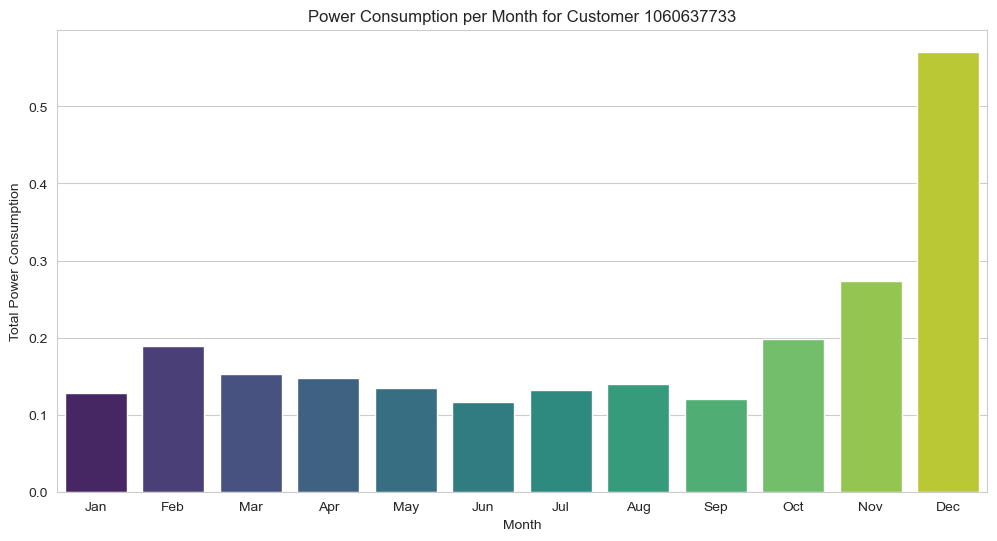

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random

# Ensure 'DATE' is in datetime format
# df_combined['DATE'] = pd.to_datetime(df_combined['DATE'])

# Randomly select one customer
random_customer = random.choice(combined_df['CUSTOMER'].unique())

# Filter the DataFrame for the randomly selected customer
customer_data = combined_df[combined_df['CUSTOMER'] == random_customer]

# Extract month from 'DATE' if not already done
customer_data['MONTH'] = customer_data['DATE'].dt.month

# Group by month and sum up 'One_Day_Power'
power_consumption_per_month = customer_data.groupby('MONTH')['One_Day_Power'].sum().reset_index()

# Sort by month for chronological order
power_consumption_per_month = power_consumption_per_month.sort_values('MONTH')

# Visualize the power consumption per month using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=power_consumption_per_month, x='MONTH', y='One_Day_Power', palette="viridis")
plt.title(f'Power Consumption per Month for Customer {random_customer}')
plt.xlabel('Month')
plt.ylabel('Total Power Consumption')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()
